# Question 1: Graph Classification

In this question we will be exploring graph classification on the dataset provided.

Overall, we will explore ways to implement graph level classification using GCNs; explore the given dataset and see how we can improve the GCN & training process overall to get a higher score on the dataset.

### HELPER FUNCTION & IMPORTS:

In [3]:
#Import Statements
import json
import torch
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [4]:
TRAIN_FILE_NAME = "q1_graph_classification_main_train.json"
EVAL_FILE_NAME = "q1_graph_classification_main_eval.json"

TRAIN_DATA_PATH = os.path.join("data",TRAIN_FILE_NAME)
EVAL_DATA_PATH = os.path.join("data",EVAL_FILE_NAME)

In [5]:
# Training function
def train_epoch(model, dataset, optimizer, criterion, return_embeddings=False, **kwargs):
    model.train()
    total_loss = 0
    all_embeddings_H1 = []
    all_labels_H1 = []

    for X, A, label in dataset:
        optimizer.zero_grad()
        # Forward pass with optional embeddings
        if return_embeddings:
            output, H1, _ = model(A, X, return_embeddings=True, **kwargs)
            all_embeddings_H1.append(H1.detach().cpu().numpy())  # Store H1 embeddings
        else:
            output = model(A, X, **kwargs)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        all_labels_H1.append(label_tensor.detach().cpu().numpy())

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)
        
        # Compute loss
        loss = criterion(output_flat, label_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataset)

    if return_embeddings:
        return average_loss, (all_embeddings_H1,all_labels_H1)
    else:
        return average_loss


# Testing function
def test(model, dataset, **kwargs):
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0

    with torch.no_grad():
        for X, A, label in dataset:
            output = model(A, X, **kwargs)

            # Convert sigmoid output to binary prediction
            predicted = (output >= 0.5).int().item()

            # Adjust labels to match binary predictions (0 and 1)
            adjusted_label = 1 if label == 1 else 0

            true_labels.append(adjusted_label)
            predicted_labels.append(predicted)
            correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    return true_labels, predicted_labels, accuracy


In [6]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 1.1 - Graph-Level Aggregation and Training

### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [7]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde. what is D_{ii}?

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


### Q1.1.a - Graph-Level GCN

Implement three graph-level aggregation methods: sum, mean, and max. A GCN implementation is provided, and your task is to adapt it into a graph-level GCN by integrating different
aggregation functions.

In [8]:
# SOLUTION Q1.1.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(MyGraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = MyGCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = MyGCNLayer(hidden_dim, 1, False)
        self.fc = nn.Linear(1, 1)

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # add self conn
        A = A + torch.eye(A.shape[0])
        
        # Normalize adjacency matrix
        epsilon = 1e-5  # Small constant to avoid division by zero
        d = A.sum(1) + epsilon
        D_inv = torch.diag(torch.pow(d, -0.5))
        A = D_inv @ A @ D_inv
        
        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)  # Output shape: (num_nodes, 1)

        if graph_aggregation_method == 'mean':
            graph_output = H2.mean(dim=0)
        elif graph_aggregation_method == 'sum':
            graph_output = H2.sum(dim=0)
        elif graph_aggregation_method == 'max':
            graph_output = H2.max(dim=0).values
        else:
            raise ValueError("Invalid graph_aggregation_method")
        
        output = self.fc(graph_output)
        output = torch.sigmoid(output)
        
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, H1, H2
        else:
            return output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

### Test your solution runs for all three aggregation methods.

Note - the input dataset features have dimensionionality 10.

### A full end-2-end Training script (make sure the below runs)

You only need to modify the aggregation parameter in this case.

In [9]:
# Preparing the Basics:
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
  (fc): Linear(in_features=1, out_features=1, bias=True)
)


In [10]:
# Training the model
random.shuffle(train_data)

# Initialize a list to store loss values for visualization
loss_values = []

# Training
num_epochs = 10

for epoch in range(num_epochs):
    # Train without returning embeddings for other epochs
    #note train_epoch accepts the additional param graph_aggregation_method and passes it (via kwargs) to the model.forward method.
    
    # ####################################################
    # MODIFY THE CODE BELOW 
    #  (note only aggregation param - and make sure to run all of them)
    # ####################################################    
    loss = train_epoch(model, train_data, optimizer, criterion, graph_aggregation_method="sum")


    # ####################################################
    # END OF MODIFICATION
    # ####################################################   
    print(f"Epoch {epoch+1}, Loss: {loss}")
    loss_values.append(loss)

Epoch 1, Loss: 0.48273546229624614
Epoch 2, Loss: 0.45814788034609094
Epoch 3, Loss: 0.4447484885229532
Epoch 4, Loss: 0.4318763473579152
Epoch 5, Loss: 0.41935067359978956
Epoch 6, Loss: 0.40738636251736543
Epoch 7, Loss: 0.395721083598663
Epoch 8, Loss: 0.38441531465981493
Epoch 9, Loss: 0.37344082702431036
Epoch 10, Loss: 0.3626387126595629


In [11]:
# Evaluate the model on the test set
true_labels, predicted_labels, accuracy = test(model, eval_data)

# Debug: Print true and predicted labels
print("True labels:", true_labels)
print("Predicted labels:", predicted_labels)

# Calculate precision, recall (sensitivity), and F1-score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print out the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-score: 0.3333


/Users/beep_kai/Desktop/Work/School Work/ICL PG/DGBL/coursework/dgl_2425_cw1/dgl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Q1.1.b. Graph-Level Training

Make modifications to the training script to:
1. Train the model and record the training loss and evaluation accuracy for each epoch.
2. Plot the test f1 for all three aggregation methods.

Use the provided functions:

• train model

• plot training and evaluation

In [12]:
# Helper function for plotting:

def plot_training_and_validation(training_losses, validation_losses, aggregation="mean", graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch",title=None):
    """
    Plots the validation accuracy and training loss over epochs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis
    epochs = range(1, len(training_losses) + 1)
    line1 = ax1.plot(epochs, training_losses, 'r-', label=f'{graph1_label}')
    ax1.set_xlabel(f"x_label")
    ax1.set_ylabel(f'{graph1_label}', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # Plot validation accuracy on the second y-axis
    line2 = ax2.plot(epochs, validation_losses, 'b-', label=f'{graph2_label}')
    ax2.set_ylabel(f'{graph2_label}', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Add title and grid
    if not title:
        title = f'Training Accuracy and Validation Accuracy Over Time\nAggregation: {aggregation}'
    plt.title(title)

    ax1.grid(True)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [13]:
# SOLUTION Q1.1.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


def train_model(model, optimizer, criterion, train_dataset, validation_dataset, epochs, graph_aggregation_method, verbose):
    """Trains the model and records loss and validation accuracy
    Should return, train_losses, train_accuracy, validation_accuracy
    """
    # INCLUDE THiS STATEMENT IN YOUR CODE
    model.train()
    train_losses = []
    train_accuracy = []
    validation_accuracy = []
    for epoch in range(epochs):
        # Train the model
        train_loss = train_epoch(model, train_dataset, optimizer, criterion, graph_aggregation_method=graph_aggregation_method)
        train_losses.append(train_loss)

        # Test the model on the training set
        _, _, train_acc = test(model, train_dataset, graph_aggregation_method=graph_aggregation_method)
        train_accuracy.append(train_acc)

        # Test the model on the validation set
        _, _, val_acc = test(model, validation_dataset, graph_aggregation_method=graph_aggregation_method)
        validation_accuracy.append(val_acc)

        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Train Accuracy: {train_acc}, Validation Accuracy: {val_acc:.4f}")
    return train_losses, train_accuracy, validation_accuracy


# ####################################################
# END OF MODIFICATION
# ####################################################  

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
  (fc): Linear(in_features=1, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.4325656146939957, Train Accuracy: 0.7992424242424242, Validation Accuracy: 0.6333
Epoch 2, Training Loss: 0.2902726656722018, Train Accuracy: 0.7954545454545454, Validation Accuracy: 0.6333
Epoch 3, Training Loss: 0.2766370211558586, Train Accuracy: 0.7992424242424242, Validation Accuracy: 0.6333
Epoch 4, Training Loss: 0.2651714257081039, Train Accuracy: 0.8106060606060606, Validation Accuracy: 0.6333
Epoch 5, Training Loss: 0.2550383829511702, Train Accuracy: 0.8333333333333334, Validation Accuracy: 0.6333
Epoch 6, Training Loss: 0.2456842113646086, Train Accuracy: 0.8409090909090909, Validation Accuracy: 0.6333
Epoch 7, Training Loss: 0.23689362713996548, Train Accuracy: 0.8560606060606061, Validation Accuracy: 0.6667
Epoch 8, Training Loss: 0.22862286675213414, Train Accuracy: 0.8825757575757576, Validation Accuracy: 0.7000
Epoch 9

<Figure size 1000x600 with 0 Axes>

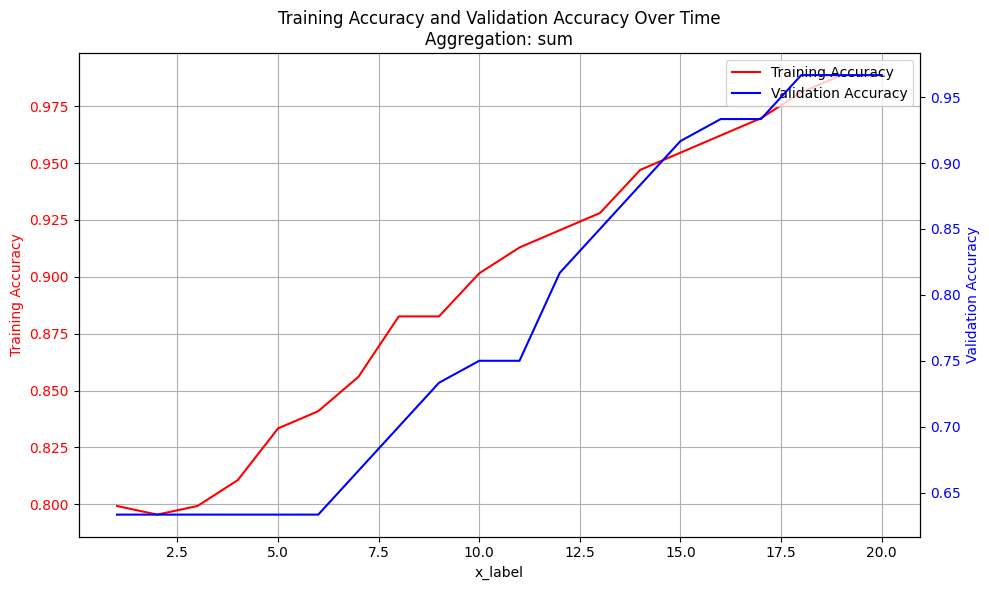

In [14]:
# Run all three aggregation functions here.
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
graph_aggregation_method = "sum"

# TRAIN
num_epochs = 20
train_losses, train_acc, eval_acc = train_model(
    model, 
    optimizer, 
    criterion, 
    train_data, 
    eval_data, 
    epochs=num_epochs, 
    graph_aggregation_method=graph_aggregation_method,
    verbose=True
)

# Visualising
plot_training_and_validation(train_acc, eval_acc, aggregation=graph_aggregation_method)

### Q1.1.c - Training vs. Evaluation F1

Additionally, compare training F1 scores vs. evaluation F1 scores. What differences do you
observe? Which aggregation function performs best and why (sum, mean, or max)?

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
  (fc): Linear(in_features=1, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.522157135560657, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 2, Training Loss: 0.32577095748010004, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 3, Training Loss: 0.31552489590125554, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 4, Training Loss: 0.3057990327308124, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 5, Training Loss: 0.29622017455315497, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 6, Training Loss: 0.2868316180608941, Train Accuracy: 0.7537878787878788, Validation Accuracy: 0.5000
Epoch 7, Training Loss: 0.27767336844099744, Train Accuracy: 0.7575757575757576, Validation Accuracy: 0.5000
Epoch 8, Training Loss: 0.26877156732547464, Train Accuracy: 0.7689393939393939, Validation Accuracy: 0.5000
Epoch 9, Training Loss: 0.2601136499592526, Train Accuracy: 0.7727272727272

<Figure size 1000x600 with 0 Axes>

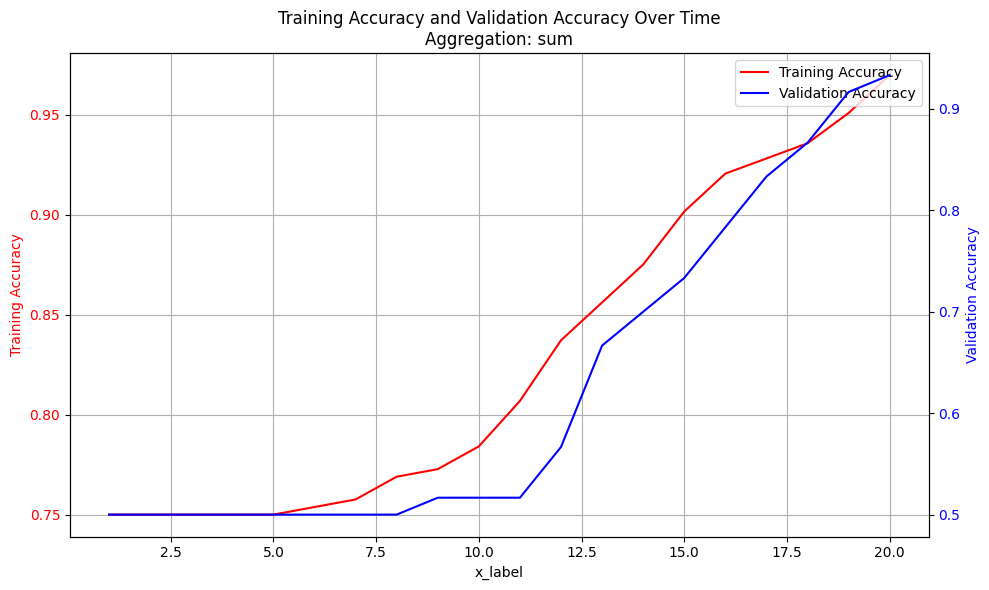

<Figure size 1000x600 with 0 Axes>

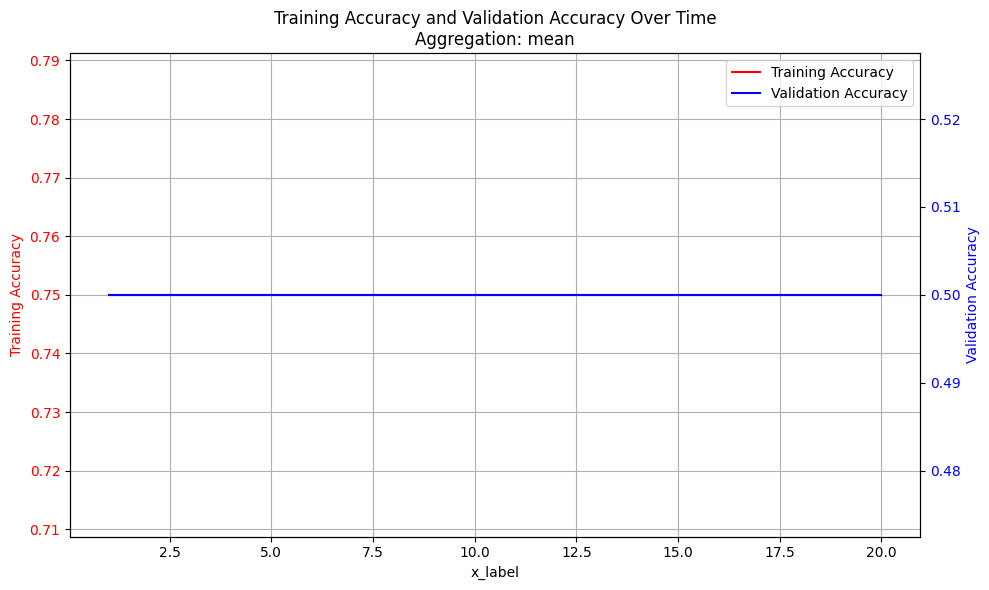

<Figure size 1000x600 with 0 Axes>

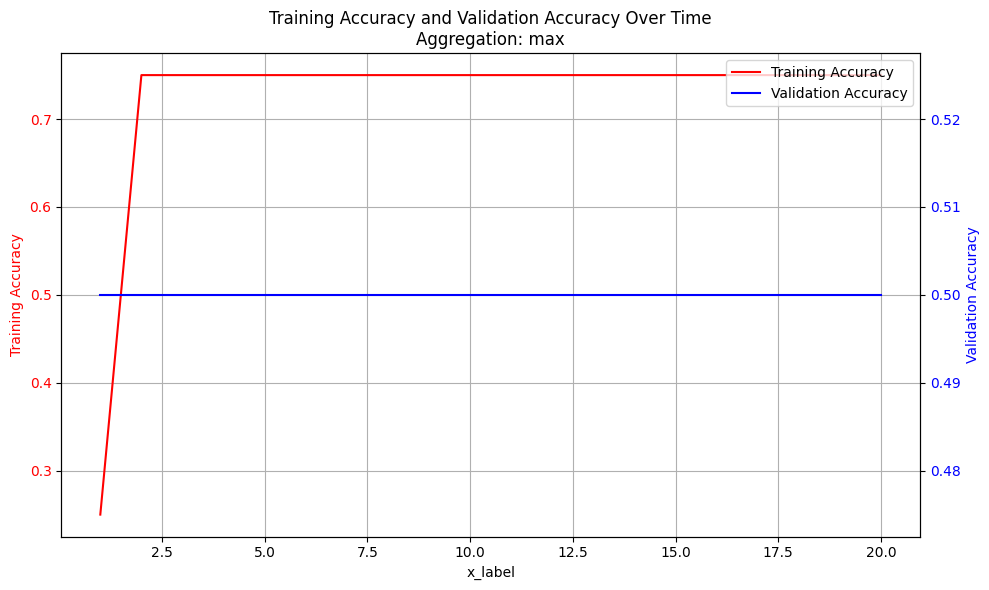

In [15]:
# Solution Q1.1.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

agg_methods = ['sum', 'mean','max']
colors = ["red", "green", "blue"]
d = dict()
for i in range(len(agg_methods)):   
    agg_method = agg_methods[i]
    color = colors[i] 
    model = MyGraphNeuralNetwork(input_dim, hidden_dim,)
    print(model)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # TRAIN
    num_epochs = 20
    train_losses, train_acc, eval_acc = train_model(
        model, 
        optimizer, 
        criterion, 
        train_data, 
        eval_data, 
        epochs=num_epochs, 
        graph_aggregation_method=agg_method,
        verbose=True,
    )
    d[agg_method] = (train_losses, train_acc, eval_acc)

# Visualising
for agg_method in agg_methods:
    train_losses, train_acc, eval_acc = d[agg_method]
    plot_training_and_validation(train_acc, eval_acc, aggregation=f'{agg_method}')


# ####################################################
# END OF MODIFICATION
# ####################################################  


## Q1.2 - Analyzing the Dataset

You may notice that the model performs worse on the evaluation dataset. The goal of this task
is to analyze the dataset and identify potential issues that might affect the model’s performance.


In [16]:
# Helper function to visualise graphs:
def visualize_graph(G):
    """Visualize the generated graph."""
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True,
        node_size=500, font_size=8, font_color="white", edge_color="gray"
    )
    plt.title("Homogenous Graph Visualization")
    plt.show()

def visualise_graph_features(features_0, features_1):
    """plot clusters and their distribution"""
    plt.figure(figsize=(12, 8))
    
    # Convert to numpy arrays and get the first feature dimension
    features_0_np_1 = np.array(features_0)[:, 0]  # Take first feature dimension
    features_0_np_2 = np.array(features_0)[:, 1]  # Take second feature dimension
    
    features_1_np_1 = np.array(features_1)[:, 0]  # Take first feature dimension
    features_1_np_2 = np.array(features_1)[:, 1]  # Take first feature dimension
   
    plt.scatter(features_0_np_1, features_0_np_2, alpha=0.6, label='Class 0', color='red')
    plt.scatter(features_1_np_1, features_1_np_2, alpha=0.6, label='Class 1', color='blue')

    plt.xlabel('First Feature Dimension')
    plt.ylabel('Class') 
    plt.title('Feature Distribution by Class')
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.legend()
    plt.show()

### Q1.2.a - Plotting
• Plot the topologies of the graphs.

• Plot the feature distributions.

• Plot the label distributions.

In [23]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
from collections import Counter
def plot_class_distribution(labels, title = None):
    """Plots the distribution of labels"""
    counts, bins = np.histogram(labels)
    plt.figure()
    plt.stairs(counts,bins)
    if title is not None:
        plt.title(title)
        
    plt.show()
    pass


def plot_graph_topology(A, title = None):
    """Plots the graph topology"""
    edge_list = np.nonzero(A).tolist()
    G = nx.Graph(edge_list)  # Create graph from adjacency matrix

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  # Compute node positions
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    if title is not None:
        plt.title(title)
    plt.show()
    pass

# ####################################################
# END OF MODIFICATION
# #################################################### 

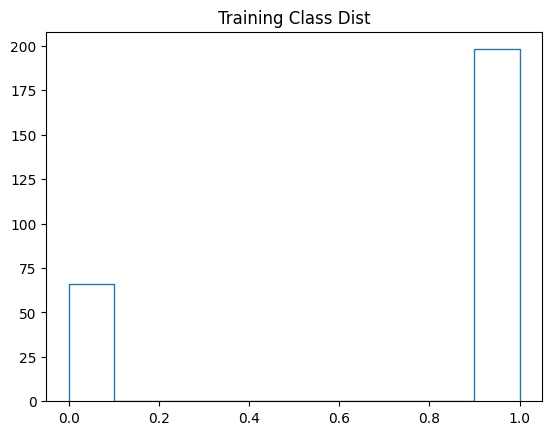

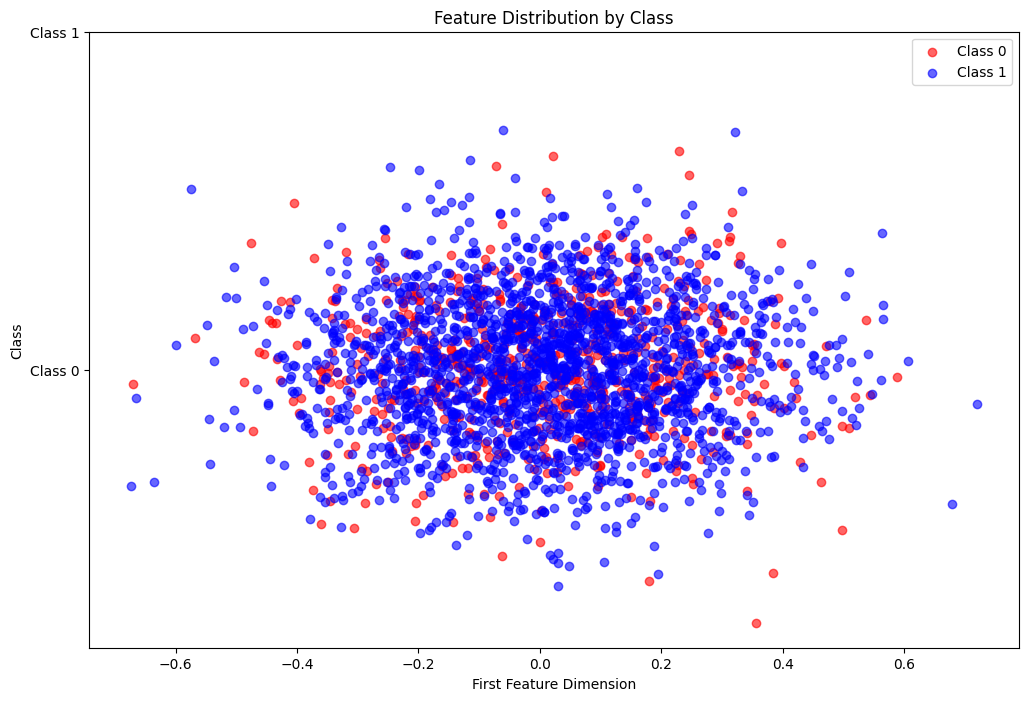

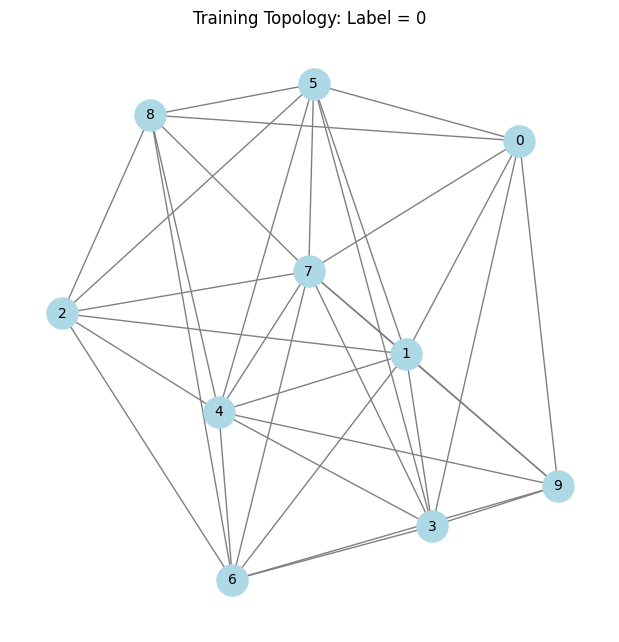

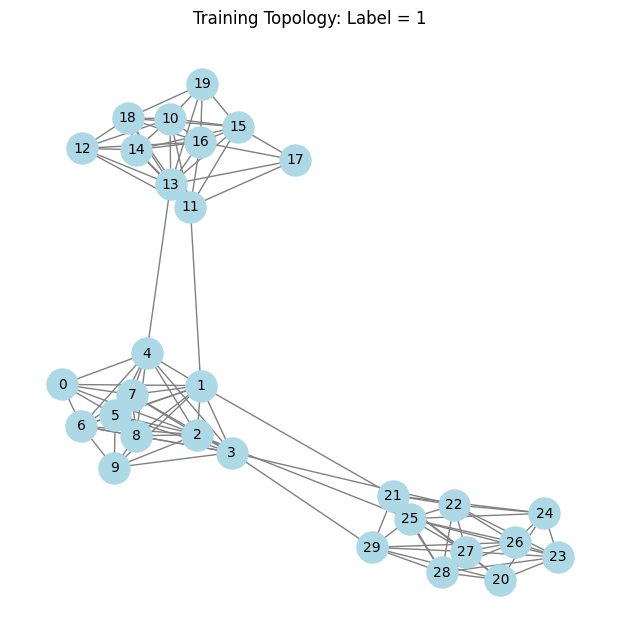

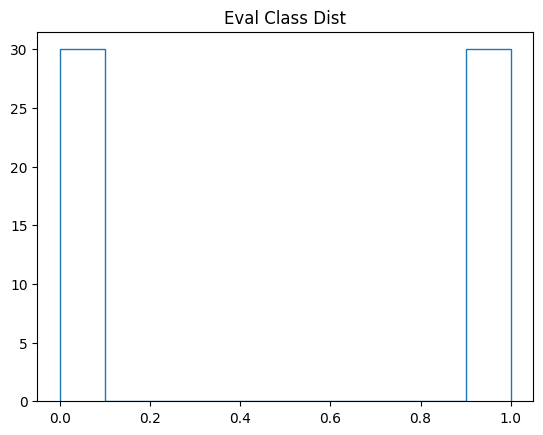

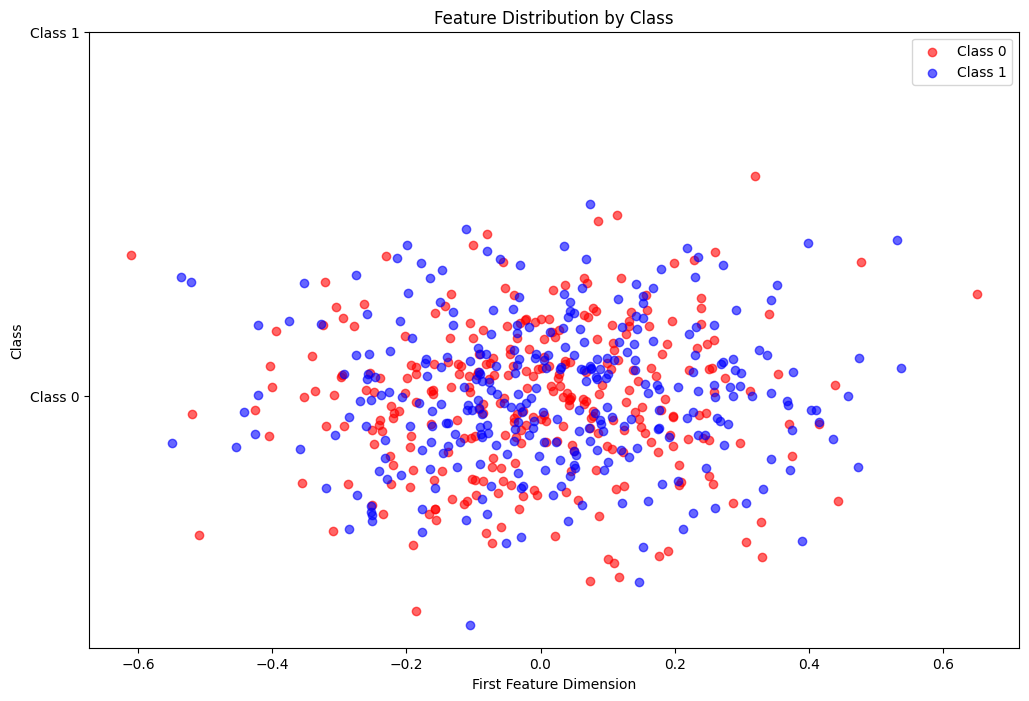

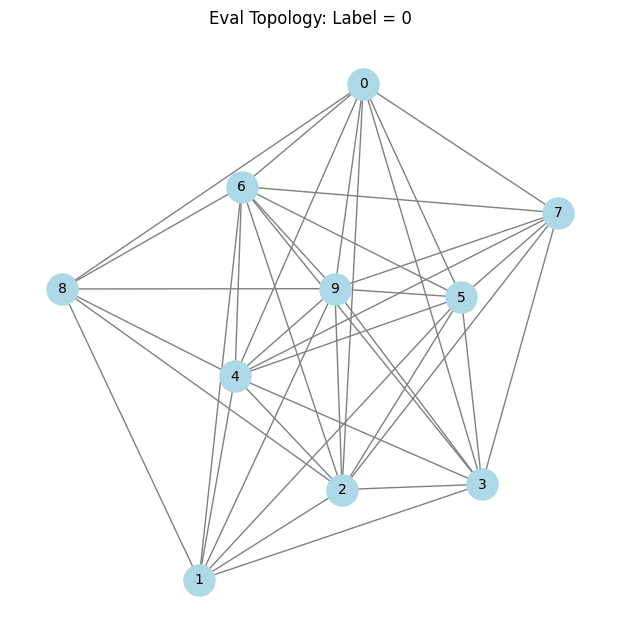

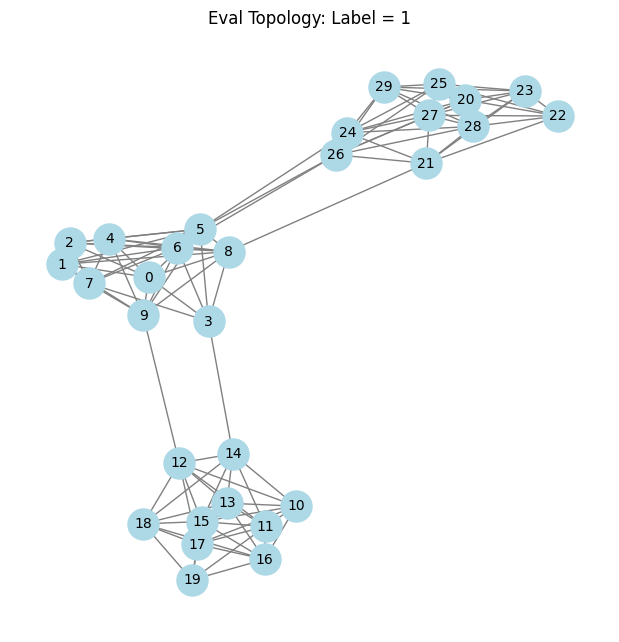

In [25]:
# Run the above scripts for train and eval. What do you observe?
def find_X_A_for_label(list_of_data,label=1):
    """Label"""
    for X,A,y in list_of_data:
        if y==label:
            return X,A

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Getting Labels
train_labels = [int(y) for _,_,y in train_data]
eval_labels = [int(y) for _,_,y in eval_data]

# Getting Features
train_features_0 = [X.numpy() for X, _, y in train_data if y == 0]
train_features_1 = [X.numpy() for X, _, y in train_data if y == 1]

eval_features_0 = [X.numpy() for X, _, y in eval_data if y == 0]
eval_features_1 = [X.numpy() for X, _, y in eval_data if y == 1]

# Find a graph for each of the classes
X0_train, A0_train = find_X_A_for_label(train_data, 0)
X1_train, A1_train = find_X_A_for_label(train_data, 1)

X0_eval,A0_eval = find_X_A_for_label(eval_data, 0)
X1_eval, A1_eval = find_X_A_for_label(eval_data, 1)

# Plotting Train
plot_class_distribution(train_labels, title='Training Class Dist')
visualise_graph_features(train_features_0, train_features_1)
plot_graph_topology(A0_train, title='Training Topology: Label = 0')
plot_graph_topology(A1_train, title='Training Topology: Label = 1')

# Plotting Eval
plot_class_distribution(eval_labels,title='Eval Class Dist')
visualise_graph_features(eval_features_0, eval_features_1)
plot_graph_topology(A0_eval, title='Eval Topology: Label = 0')
plot_graph_topology(A1_eval, title='Eval Topology: Label = 1')





## Question 1.3 - Overcoming Dataset Challenges

In this section, you will attempt to address the challenges identified by improving the model or training process.

### Q1.3.a - Adapting the GCN

Modify your GCN implementation from Q1.1 to accept the number of layers and output dimen-
sion (i.e. the graph embedding dimension) as parametes. Experiment with different hyperparam-
eters, such as:

• Number of layers.

• Hidden dimension size.

You will implement:

• Implement GCN as described above.

• Experiment with hyperparameters and report the results and plots.

Hint: The ModuleList class might be useful.

In [41]:
# SOLUTION Q1.3.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer2(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer2, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork2(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=1, output_dim=1):
        super(MyGraphNeuralNetwork2, self).__init__()   
        self.l_in = nn.Linear(input_dim, hidden_dim)
        # self.gcn_in = MyGCNLayer2(input_dim, hidden_dim, use_nonlinearity=True)
        # self.gcns = nn.ModuleList([MyGCNLayer2(hidden_dim, hidden_dim, use_nonlinearity=True) for _ in range(num_layers-2)])
        self.gcns = nn.ModuleList([MyGCNLayer2(hidden_dim, hidden_dim, use_nonlinearity=True) for _ in range(num_layers-1)])
        self.gcn_out = MyGCNLayer2(hidden_dim, output_dim, use_nonlinearity = False)
        self.l_out = nn.Linear(output_dim, 1) # linear layer to map graph output to output dim
        self.relu = nn.ReLU()
        pass

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):        # add self conn
        A = A + torch.eye(A.shape[0])
        
        # Normalize adjacency matrix
        epsilon = 1e-5  # Small constant to avoid division by zero
        d = A.sum(1) + epsilon
        D_inv = torch.diag(torch.pow(d, -0.5))
        A = D_inv @ A @ D_inv
        graph_embedding = {}
        
        H = self.l_in(X) # pass into linear layer first
        
        # H = self.gcn_in(X,A)
        # graph_embedding['H0'] = H
        
        # Pass through GCN layers
        for i,gcn in enumerate(self.gcns):
            H = gcn(H,A)
            key = f'H{i+1}'
            graph_embedding[key] = H
        H = self.gcn_out(H,A)
        
        # aggregation
        if graph_aggregation_method == 'mean':
            graph_output = H.mean(dim=0)
        elif graph_aggregation_method == 'sum':
            graph_output = H.sum(dim=0)
        elif graph_aggregation_method == 'max':
            graph_output = H.max(dim=0).values
        else:
            raise ValueError("Invalid graph_aggregation_method")
        
        # Pass through linear output layer
        output = self.l_out(graph_output)
        # output = nn.Softmax()(output)
        output = torch.sigmoid(output)
        
        
        if kwargs.get("return_graph_embedding", None):
            return output, graph_embedding
        else:
            return output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

In [33]:
def split_training_data(data,proportion):
    valid_data_size = int(len(data) * proportion)  # Convert to integer correctly
    train_data = data[:valid_data_size]
    valid_data = data[valid_data_size:]
    return train_data, valid_data

MyGraphNeuralNetwork2(
  (l_in): Linear(in_features=10, out_features=8, bias=True)
  (gcns): ModuleList(
    (0): MyGCNLayer2()
  )
  (gcn_out): MyGCNLayer2()
  (l_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch 1, Training Loss: 0.4846801138460919, Train Accuracy: 0.7535545023696683, Validation Accuracy: 0.5000
Epoch 2, Training Loss: 0.32001406697653484, Train Accuracy: 0.7535545023696683, Validation Accuracy: 0.5000
Epoch 3, Training Loss: 0.3118752041275467, Train Accuracy: 0.7535545023696683, Validation Accuracy: 0.5000
Epoch 4, Training Loss: 0.3036180148651532, Train Accuracy: 0.7535545023696683, Validation Accuracy: 0.5000
Epoch 5, Training Loss: 0.2948422221140274, Train Accuracy: 0.7535545023696683, Validation Accuracy: 0.5000
Epoch 6, Training Loss: 0.2862565417407672, Train Accuracy: 0.7630331753554502, Validation Accuracy: 0.5000
Epoch 7, Training Loss: 0.2775623888148092, Train Accuracy: 0.7630331753554502, Validation Accuracy: 0.5000
Epoch

<Figure size 1000x600 with 0 Axes>

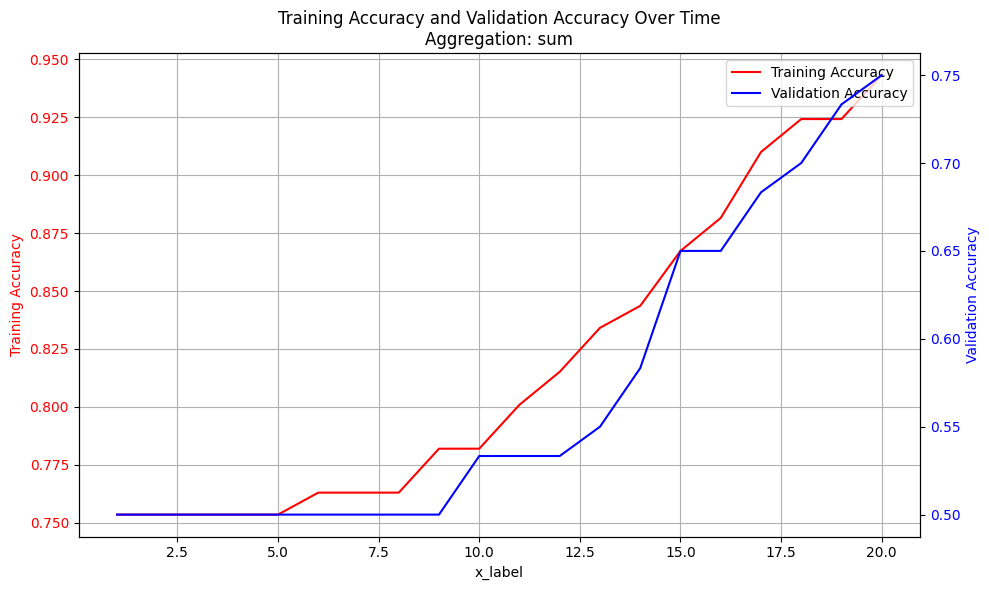

In [ ]:
# Run different hyper params here

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
layers = 2
output_dim = 8
model = MyGraphNeuralNetwork2(input_dim, hidden_dim, output_dim=output_dim, num_layers = layers)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Splitting the Data

train_data, val_data = split_training_data(train_data,0.8)
# TRAIN
num_epochs = 40
train_losses, train_acc, eval_acc = train_model(
    model, 
    optimizer, 
    criterion, 
    train_data, 
    eval_data, #plotting eval data on purpose to see how eval dataset performance looks like
    epochs=num_epochs, 
    graph_aggregation_method="sum",
    verbose=True
)

# Visualising
plot_training_and_validation(train_acc, eval_acc, "sum")

### Q1.3.b - Improving the Model
Identify and implement three different methods to overcome the challenges discovered in
Q1.2. Your goal is to achieve the highest possible score. You may experiment with:

• Model architecture modifications.

• Data preprocessing techniques.

• Hyperparameter tuning.

• Loss function adjustments.

<Figure size 1000x600 with 0 Axes>

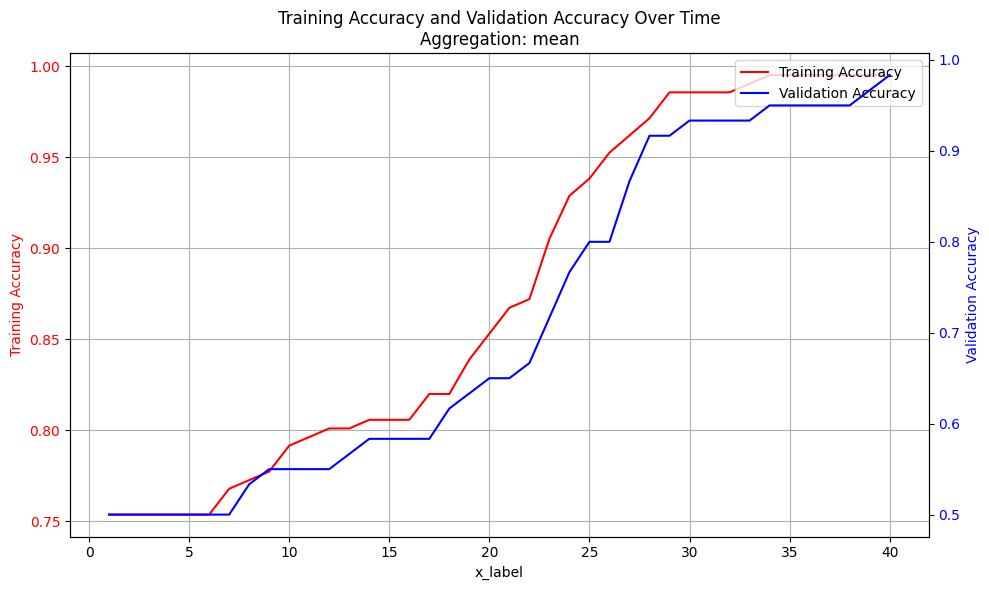

In [38]:
# SOLUTION Q1.3.b

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################


# Call this function in the end.
plot_training_and_validation(train_acc, eval_acc)

# ####################################################
# END OF MODIFICATION
# ####################################################

### Q1.3.c - Evaluating the Best Model

Plot the performance of your best model over 100 epochs or more, averaged over multiple
random (i.i.d.) runs (at least 10 runs) to produce a smoothed training and evaluation accuracy
curve. 

Note: Your score will be based on the smoothed curve.

Hints:

• Set verbose=False in the train model function to suppress excessive logging.

• Use np.mean with an axis parameter to compute the average performance over multiple
runs.


MyGraphNeuralNetwork2(
  (l_in): Linear(in_features=10, out_features=8, bias=True)
  (gcns): ModuleList(
    (0): MyGCNLayer2()
  )
  (gcn_out): MyGCNLayer2()
  (l_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


<Figure size 1000x600 with 0 Axes>

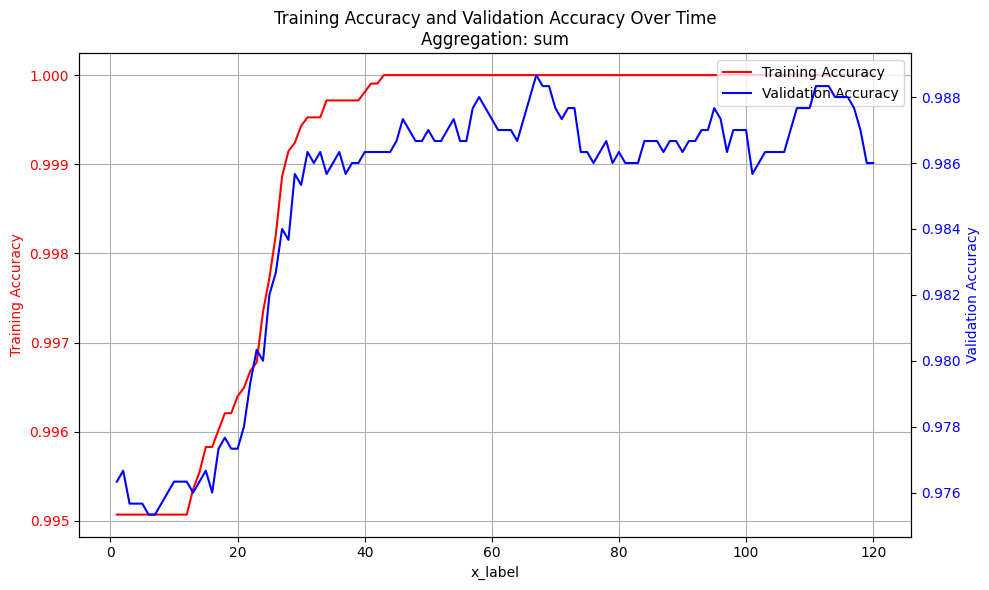

In [51]:
# SOLUTION Q1.3.c - Smooth Curve

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
layers = 2
output_dim = 8
model = MyGraphNeuralNetwork2(input_dim, hidden_dim, output_dim=output_dim, num_layers = layers)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Splitting the Data

train_data, val_data = split_training_data(train_data,0.8)
# TRAIN
num_epochs = 120
rounds = 50
train_accs = np.zeros((rounds,num_epochs))
eval_accs = np.zeros((rounds,num_epochs))
for idx in range(rounds):
    train_losses, train_acc, eval_acc = train_model(
        model, 
        optimizer, 
        criterion, 
        train_data, 
        eval_data, #plotting eval data on purpose to see how eval dataset performance looks like
        epochs=num_epochs, 
        graph_aggregation_method="sum",
        verbose=False
    )
    train_accs[idx,:] = train_acc
    eval_accs[idx,:] = eval_acc

averaged_train_acc = np.mean(train_accs,axis=0)
averaged_eval_acc = np.mean(eval_accs,axis=0)

# Call this function in the end (with the averaged values)
plot_training_and_validation(averaged_train_acc, averaged_eval_acc, aggregation='sum')

# ####################################################
# END OF MODIFICATION
# ####################################################